# Clasificacion de Residuos solidos usando CNN y ConvNeXT
**Nombre:** Brayan Simpon Polo Orellana

**GitHub:** https://github.com/bspoloo/SIS421-022025/tree/main/Laboratorios/Laboratorio%201/ConvNeXT

En este laboratorio sobre una Red neuronal convolucional para la clasificación de imágenes mediante Trasnfer learning, aplicando fine tunning y freezeando la ultima capa de un modelo preentrenado.

# Convolutional Neural Network (CNN)

## Introducción

En este proyecto implementamos nuestra primera red neuronal convolucional (CNN) utilizando PyTorch.Las CNNs son ampliamente utilizadas en visión por computadora por su capacidad de extraer características jerárquicas de las imágenes.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Usar GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# Normalización típica para imágenes RGB
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # Ajustamos tamaño
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización en [-1, 1]
])

# Dataset
trainset = torchvision.datasets.ImageFolder(root=r"C:\Users\Admin\Ciencias\Residuos solidos\data\train", transform=transform)
testset  = torchvision.datasets.ImageFolder(root=r"C:\Users\Admin\Ciencias\Residuos solidos\data\val",  transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes
print("Clases detectadas:", classes)

Clases detectadas: ['Baldes de plastico', 'Conservas de cafe', 'Filtros de acite de auto', 'Llantas', 'Talpas de baldes']


## Arquitectura de la Red

Nuestra CNN está compuesta por:
- **Capa 1:** Convolucional + ReLU + MaxPooling  
- **Capa 2:**Convolucional + ReLU + MaxPooling  Capa Fully Connected 
- **(FC):** Conexión total hacia las clases de salida

Representación de la arquitectura:

In [3]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        nn.ReLU(),
        nn.MaxPool2d(pk, stride=ps)
    )

class CNN(nn.Module):
    def __init__(self, n_channels=3, n_outputs=5):  # 3 canales RGB, 5 clases
        super().__init__()
        self.conv1 = block(n_channels, 32)   # 3 -> 32 filtros
        self.conv2 = block(32, 64)           # 32 -> 64 filtros
        self.conv3 = block(64, 128)          # 64 -> 128 filtros
        self.fc = nn.Linear(128 * 8 * 8, n_outputs)  # ajusta según el tamaño final

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=8192, out_features=5, bias=True)
)


In [4]:
import numpy as np

def fit(model, trainloader, testloader, epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        # ---- Entrenamiento ----
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(trainloader, desc=f"Epoch {epoch}/{epochs} [Train]")
        for X, y in bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_loss.append(loss.item())
            train_acc.append(acc)
            bar.set_postfix(loss=f"{np.mean(train_loss):.4f}", acc=f"{np.mean(train_acc):.4f}")

        # ---- Validación ----
        model.eval()
        val_loss, val_acc = [], []
        with torch.no_grad():
            for X, y in testloader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_loss.append(loss.item())
                val_acc.append(acc)

        # Guardar métricas
        history["train_loss"].append(np.mean(train_loss))
        history["train_acc"].append(np.mean(train_acc))
        history["val_loss"].append(np.mean(val_loss))
        history["val_acc"].append(np.mean(val_acc))

        print(f"Epoch {epoch}: Train Loss {np.mean(train_loss):.4f}, "
              f"Train Acc {np.mean(train_acc):.4f}, "
              f"Val Loss {np.mean(val_loss):.4f}, "
              f"Val Acc {np.mean(val_acc):.4f}")

    return history

In [5]:
history = fit(model, trainloader, testloader, epochs=30, lr=1e-3)

Epoch 1/30 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s, acc=0.5797, loss=1.1020]


Epoch 1: Train Loss 1.1020, Train Acc 0.5797, Val Loss 0.8825, Val Acc 0.6379


Epoch 2/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.78it/s, acc=0.8105, loss=0.5391]


Epoch 2: Train Loss 0.5391, Train Acc 0.8105, Val Loss 0.3698, Val Acc 0.8789


Epoch 3/30 [Train]: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s, acc=0.8980, loss=0.2901]


Epoch 3: Train Loss 0.2901, Train Acc 0.8980, Val Loss 0.2795, Val Acc 0.9014


Epoch 4/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.82it/s, acc=0.9340, loss=0.1997]


Epoch 4: Train Loss 0.1997, Train Acc 0.9340, Val Loss 0.2739, Val Acc 0.9010


Epoch 5/30 [Train]: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s, acc=0.9648, loss=0.1079]


Epoch 5: Train Loss 0.1079, Train Acc 0.9648, Val Loss 0.1609, Val Acc 0.9316


Epoch 6/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.77it/s, acc=0.9809, loss=0.0703]


Epoch 6: Train Loss 0.0703, Train Acc 0.9809, Val Loss 0.1220, Val Acc 0.9624


Epoch 7/30 [Train]: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s, acc=0.9891, loss=0.0390]


Epoch 7: Train Loss 0.0390, Train Acc 0.9891, Val Loss 0.1827, Val Acc 0.9297


Epoch 8/30 [Train]: 100%|██████████| 40/40 [00:15<00:00,  2.51it/s, acc=0.9938, loss=0.0264]


Epoch 8: Train Loss 0.0264, Train Acc 0.9938, Val Loss 0.1285, Val Acc 0.9629


Epoch 9/30 [Train]: 100%|██████████| 40/40 [00:15<00:00,  2.54it/s, acc=0.9934, loss=0.0250]


Epoch 9: Train Loss 0.0250, Train Acc 0.9934, Val Loss 0.1063, Val Acc 0.9668


Epoch 10/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.67it/s, acc=0.9973, loss=0.0121]


Epoch 10: Train Loss 0.0121, Train Acc 0.9973, Val Loss 0.0842, Val Acc 0.9766


Epoch 11/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.71it/s, acc=0.9996, loss=0.0040]


Epoch 11: Train Loss 0.0040, Train Acc 0.9996, Val Loss 0.0782, Val Acc 0.9766


Epoch 12/30 [Train]: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s, acc=1.0000, loss=0.0023]


Epoch 12: Train Loss 0.0023, Train Acc 1.0000, Val Loss 0.0760, Val Acc 0.9785


Epoch 13/30 [Train]: 100%|██████████| 40/40 [00:15<00:00,  2.57it/s, acc=1.0000, loss=0.0013]


Epoch 13: Train Loss 0.0013, Train Acc 1.0000, Val Loss 0.0731, Val Acc 0.9805


Epoch 14/30 [Train]: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s, acc=1.0000, loss=0.0010]


Epoch 14: Train Loss 0.0010, Train Acc 1.0000, Val Loss 0.0758, Val Acc 0.9785


Epoch 15/30 [Train]: 100%|██████████| 40/40 [00:15<00:00,  2.51it/s, acc=1.0000, loss=0.0009]


Epoch 15: Train Loss 0.0009, Train Acc 1.0000, Val Loss 0.0729, Val Acc 0.9805


Epoch 16/30 [Train]: 100%|██████████| 40/40 [00:16<00:00,  2.38it/s, acc=1.0000, loss=0.0007]


Epoch 16: Train Loss 0.0007, Train Acc 1.0000, Val Loss 0.0802, Val Acc 0.9766


Epoch 17/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.73it/s, acc=1.0000, loss=0.0006]


Epoch 17: Train Loss 0.0006, Train Acc 1.0000, Val Loss 0.0734, Val Acc 0.9824


Epoch 18/30 [Train]: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s, acc=1.0000, loss=0.0005]


Epoch 18: Train Loss 0.0005, Train Acc 1.0000, Val Loss 0.0709, Val Acc 0.9805


Epoch 19/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.82it/s, acc=1.0000, loss=0.0005]


Epoch 19: Train Loss 0.0005, Train Acc 1.0000, Val Loss 0.0726, Val Acc 0.9805


Epoch 20/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.80it/s, acc=1.0000, loss=0.0004]


Epoch 20: Train Loss 0.0004, Train Acc 1.0000, Val Loss 0.0771, Val Acc 0.9785


Epoch 21/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.76it/s, acc=1.0000, loss=0.0004]


Epoch 21: Train Loss 0.0004, Train Acc 1.0000, Val Loss 0.0752, Val Acc 0.9785


Epoch 22/30 [Train]: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s, acc=1.0000, loss=0.0003]


Epoch 22: Train Loss 0.0003, Train Acc 1.0000, Val Loss 0.0769, Val Acc 0.9824


Epoch 23/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s, acc=1.0000, loss=0.0003]


Epoch 23: Train Loss 0.0003, Train Acc 1.0000, Val Loss 0.0760, Val Acc 0.9805


Epoch 24/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.76it/s, acc=1.0000, loss=0.0003]


Epoch 24: Train Loss 0.0003, Train Acc 1.0000, Val Loss 0.0767, Val Acc 0.9785


Epoch 25/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.79it/s, acc=1.0000, loss=0.0002]


Epoch 25: Train Loss 0.0002, Train Acc 1.0000, Val Loss 0.0785, Val Acc 0.9785


Epoch 26/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.70it/s, acc=1.0000, loss=0.0002]


Epoch 26: Train Loss 0.0002, Train Acc 1.0000, Val Loss 0.0786, Val Acc 0.9805


Epoch 27/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.76it/s, acc=1.0000, loss=0.0002]


Epoch 27: Train Loss 0.0002, Train Acc 1.0000, Val Loss 0.0774, Val Acc 0.9805


Epoch 28/30 [Train]: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s, acc=1.0000, loss=0.0002]


Epoch 28: Train Loss 0.0002, Train Acc 1.0000, Val Loss 0.0810, Val Acc 0.9785


Epoch 29/30 [Train]: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s, acc=1.0000, loss=0.0002]


Epoch 29: Train Loss 0.0002, Train Acc 1.0000, Val Loss 0.0786, Val Acc 0.9805


Epoch 30/30 [Train]: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s, acc=1.0000, loss=0.0002]


Epoch 30: Train Loss 0.0002, Train Acc 1.0000, Val Loss 0.0820, Val Acc 0.9805


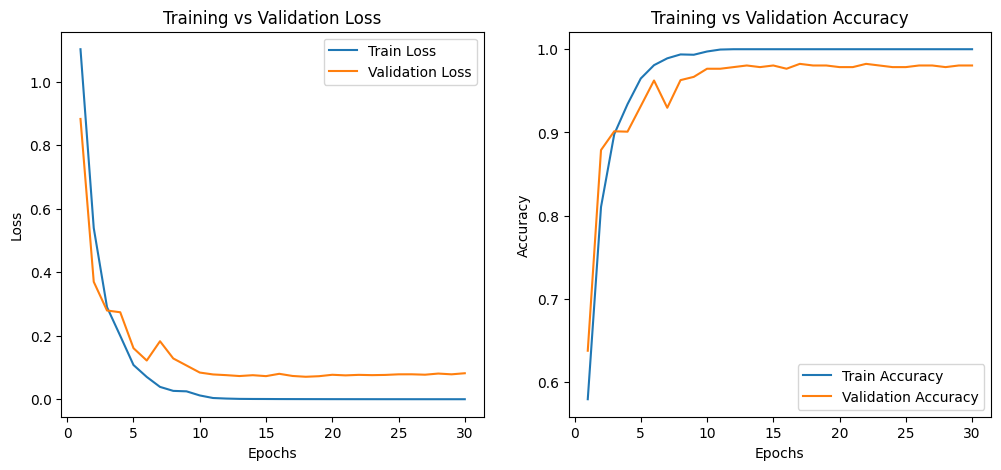

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"])+1)

plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()

- **Optimizador:** Adam  
- **Función de pérdida:** CrossEntropyLoss
- **Épocas de entrenamiento:** 30
- **Batch size:** 64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.88235295].


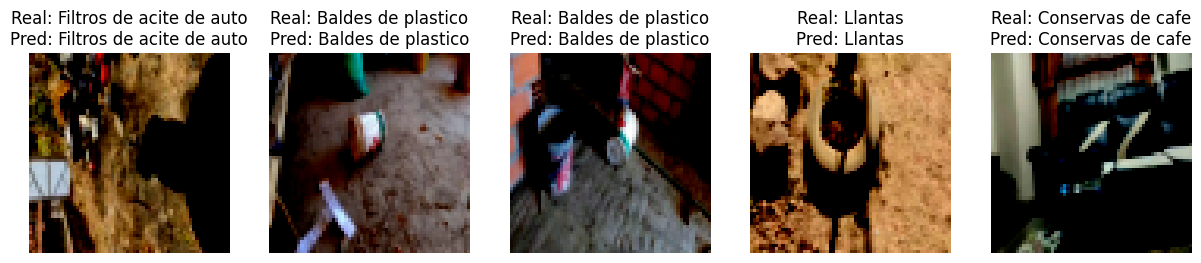

In [7]:
import random

# Ponemos el modelo en modo evaluación
model.eval()

# Seleccionar 5 índices aleatorios del dataset de prueba
indices = random.sample(range(len(testset)), 5)

plt.figure(figsize=(15,5))

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, label = testset[idx]   # (imagen, etiqueta real)
        img_input = img.unsqueeze(0).to(device)  # añadir batch dimension
        
        # Predicción
        output = model(img_input)
        pred = torch.argmax(output, axis=1).item()
        
        # Mostrar imagen con etiquetas
        plt.subplot(1, 5, i+1)
        plt.imshow(img.permute(1, 2, 0).cpu())  # de (C,H,W) → (H,W,C)
        plt.title(f"Real: {classes[label]}\nPred: {classes[pred]}")
        plt.axis("off")

plt.show()

- **Precisión en entrenamiento:** ~93%
- **Precisión en validación:** ~98%

# Que es ConvNeXT

ConvNeXt es una arquitectura de visión por computadora (CNN) desarrollada por Facebook AI en 2022.
La idea fue modernizar las CNNs clásicas (ResNet) con mejoras inspiradas en los Transformers (ViT), pero manteniendo solo convoluciones.

¿Qué pasa si actualizamos ResNet con las técnicas modernas de Transformers, pero sin usar auto-atención?

ConvNeXT es una arquitectura de red neuronal convolucional moderna, inspirada en los Transformers, pero usando convoluciones. Su objetivo es cerrar la brecha de desempeño entre CNNs y Transformers en visión, manteniendo la eficiencia computacional de las CNNs. ConvNeXT Tiny es la versión más pequeña, adecuada para datasets medianos o pruebas rápidas.

**Detalles Clave de ConvNeXT**

- Depthwise Convolutions (k=7x7): Reemplazan self-attention de ViT, capturando contexto global eficientemente.

- Inversión de Bottleneck: Primero expande canales (x4) y luego reduce, contrario a ResNet.

- LayerNorm (LN): Usado en lugar de BatchNorm, crucial para estabilidad.

- GELU vs ReLU: Mejor rendimiento en tareas complejas.

- Residual Connections: Como en ResNet, facilitan el entrenamiento profundo.

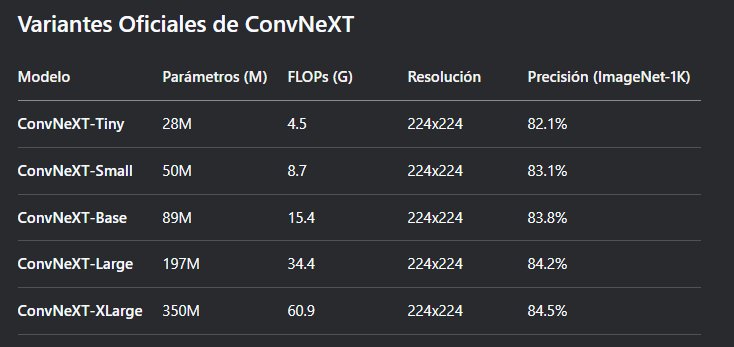

**¿Por qué ConvNeXT es poderoso?**

- Eficiencia: Más rápido que ViT en entrenamiento (sin self-attention costosa).
- Precisión: Supera a ResNet y Swin Transformers en ImageNet.
- Simplicidad: Solo usa convoluciones, evitando complejidad de Transformers.

**Principios clave:**

- Usa bloques de convolución 2D modernos.
- Reemplaza algunas operaciones clásicas de CNN por LayerNorm, Depthwise Convolutions, y residual connections inspiradas en Transformers.
- Mantiene la eficiencia para entrenar en GPU estándar.

<img src="./ConvNeXT/ConvNeXT architecture.png" alt="ConvNeXT Architecture" width="20%" />

### 1. Input Image (224x224x3)
Entrada: Una imagen RGB de tamaño 224x224 píxeles con 3 canales (rojo, verde, azul).

### 2. Stem (Conv 4x4, stride 4)
Objetivo: Reemplaza el patch embedding de los Vision Transformers (ViT) con una convolución tradicional.

**Operación:**

- Aplica una convolución 4x4 con stride=4 (deslizamiento de 4 píxeles).
- Salida: Reduce la resolución espacial y extrae características iniciales.
- Tamaño de salida: 56x56x96 (96 canales de características).

### 3. Etapas (Stages 1-4)
Cada etapa reduce la resolución espacial y aumenta los canales, similar a ResNet pero con bloques modernizados.

**Stage 1 (56x56x96 → 28x28x192)**
Bloque ConvNeXT:

- **Depthwise Convolution (Conv 7x7, grupos=canales):** Captura información espacial como en los ViT.

- **LayerNorm (LN):** Normaliza por canal (mejor que BatchNorm para batches pequeños).

- **Conv 1x1 (Expansión):** Aumenta canales temporalmente (ej: de 96 a 384).

- **GELU Activation:** Función de activación no lineal. (Gaussian Error Linear Unit)

- **Conv 1x1 (Reducción):** Vuelve a los canales originales (192 en Stage 1).

- **Conexión Residual:** Suma la entrada original (como en ResNet).

- **Downsample:** Reducción de resolución a 28x28 (usando LayerNorm + Conv 2x2, stride=2).

**Stage 2 (28x28x192 → 14x14x384)**
- Misma estructura, pero con más canales (384). La resolución se reduce a 14x14.

**Stage 3 (14x14x384 → 7x7x768)**
- Aumenta canales a 768 y reduce resolución a 7x7.

**Stage 4 (7x7x768 → 768)**
- Última etapa sin reducción espacial. Las características se mantienen en 768 canales.

### 4. Global Average Pooling (GAP)
Reduce cada canal 7x7 a un solo valor promedio.

Entrada: 7x7x768 → Salida: 1x1x768.

### 5. LayerNorm
Normalización final para estabilizar los valores antes de la clasificación.

### 6. Fully Connected (Linear Layer)
Capa lineal que mapea los 768 canales a num_classes (ej: 1000 clases en ImageNet).

**Salida:** Logits (puntuaciones para cada clase).

## Fine tunning con ConvNeXT

En lugar de una inicialización aleatoria, inicializamos la red con una red preentrenada, como la que se entrena con el conjunto de datos imagenet 1000. El resto del entrenamiento se desarrolla de forma normal.

In [8]:
# ======================
# 🔹 PyTorch principal
# ======================
import torch                      # Librería base de PyTorch (tensores, operaciones en CPU/GPU)
import torch.nn as nn             # Construcción de redes neuronales (capas, pérdidas, activaciones)
import torch.optim as optim       # Optimizadores (SGD, Adam, RMSprop, etc.)
from torch.optim import lr_scheduler  # Planificadores de tasa de aprendizaje
import torch.backends.cudnn as cudnn  # Optimizaciones para GPU con cuDNN (NVIDIA)

# ======================
# 🔹 NumPy
# ======================
import numpy as np                # Cálculo científico y manejo de arrays

# ======================
# 🔹 TorchVision
# ======================
import torchvision                 # Librería de visión por computadora para PyTorch
from torchvision import datasets, models, transforms
# datasets  → carga datasets comunes (ImageNet, CIFAR, MNIST…)
# models    → modelos preentrenados (ResNet, ConvNeXt, EfficientNet, etc.)
# transforms → transformaciones de imágenes (resize, crop, normalización)

# ======================
# 🔹 Visualización
# ======================
import matplotlib.pyplot as plt   # Graficar curvas, imágenes y resultados

# ======================
# 🔹 Utilidades generales
# ======================
import time                       # Medir tiempos (entrenamiento, inferencia, etc.)
import os                         # Manejo de archivos y rutas
from PIL import Image             # Procesamiento de imágenes (abrir, convertir, manipular)
from tempfile import TemporaryDirectory  # Crear carpetas temporales (para datasets/resultados)

# ======================
# 🔹 Configuraciones extra
# ======================
cudnn.benchmark = True   # Acelera el entrenamiento en GPU si las entradas tienen tamaño fijo
plt.ion()               # Activa modo interactivo en matplotlib (los gráficos no bloquean el script)


## Carga de datos

Usaremos los paquetes torchvision y torch.utils.data para cargar los datos.

El problema que resolveremos es entrenar un modelo para clasificar:

- Llantas
- Baldes de plastico
- Filtros de aceite de auto
- Tapas de baldes
- Conservas de cafe

Contamos con unas 35.805 imágenes de entrenamiento para cada una de ellas. tomaremos el 20% de validacion de cada clase. No

Este conjunto de datos es un subconjunto muy pequeño de imagenet.

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r"C:\Users\Admin\Ciencias\Residuos solidos\data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## Visualizacion de imagenes

Visualicemos algunas imágenes de entrenamiento para comprender las ampliaciones de datos.

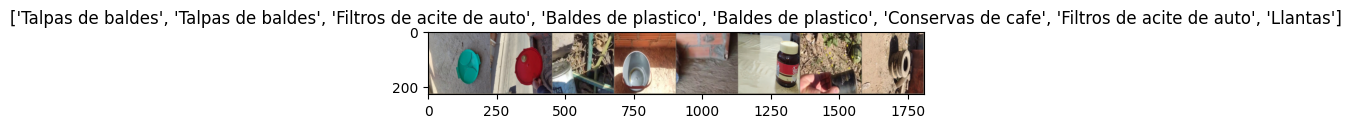

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Entrenamiento del modelo

Ahora, escribamos una función general para entrenar un modelo. A continuación, ilustraremos:

- Programación de la tasa de aprendizaje
- Guardar el mejor modelo

A continuación, el parámetro "scheduler" es un objeto "scheduler" de LR de **torch.optim.lr_scheduler**.

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Listas para almacenar métricas
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    all_labels = {'train': [], 'val': []}
    all_preds = {'train': [], 'val': []}

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                phase_labels = []
                phase_preds = []

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    # Guardar labels y predicciones para matriz de confusión
                    phase_labels.extend(labels.cpu().numpy())
                    phase_preds.extend(preds.cpu().numpy())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                # Almacenar métricas
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.cpu().numpy())
                    all_labels['train'].extend(phase_labels)
                    all_preds['train'].extend(phase_preds)
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.cpu().numpy())
                    all_labels['val'].extend(phase_labels)
                    all_preds['val'].extend(phase_preds)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    
    # Devolver modelo y métricas
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'all_labels': all_labels,
        'all_preds': all_preds
    }

In [12]:
def plot_training_metrics(metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfica de pérdidas
    ax1.plot(metrics['train_losses'], label='Train Loss', color='blue')
    ax1.plot(metrics['val_losses'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Gráfica de accuracy
    ax2.plot(metrics['train_accuracies'], label='Train Accuracy', color='blue')
    ax2.plot(metrics['val_accuracies'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(labels, preds, class_names=None):
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

## Visualizando las predicciones del modelo
Funcion generica para mostrar predicciones para unas pocas imagenes


In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [16]:
import torch
import torch.nn as nn
from torchvision import models

# Limpiar caché de CUDA antes de empezar
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Verificar memoria disponible
if torch.cuda.is_available():
    print(f"Memoria GPU total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Memoria GPU reservada: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    print(f"Memoria GPU asignada: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

Usando dispositivo: cuda
Memoria GPU total: 6.00 GB
Memoria GPU reservada: 0.04 GB
Memoria GPU asignada: 0.02 GB


## Finetuning al ConvNeXT

Cargamos un modelo previamente entrenado y restablezca la capa final completamente conectada.

Primero imprimimos las clases disponibles:

In [19]:
all_labels = []
for _, labels in dataloaders['train']:
    all_labels.extend(labels.tolist())
print("Clases únicas:", set(all_labels))

Clases únicas: {0, 1, 2, 3, 4}


In [27]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar ConvNeXt Tiny preentrenado
model_ft = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Ajustar la capa final (classifier) al número de clases
num_ftrs = model_ft.classifier[2].in_features
model_ft.classifier[2] = nn.Linear(num_ftrs, 5)  # 5 clases

# Mover el modelo al dispositivo
model_ft = model_ft.to(device)

# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## Entrenamiento y evaluacion

Debería tardar entre 15 y 25 minutos en la CPU. Sin embargo, en la GPU, tarda menos de un minuto.

In [28]:
import gc
import torch

# Antes de entrenar
torch.cuda.empty_cache()
gc.collect()

# Verificar estado de memoria
if torch.cuda.is_available():
    print(f"Memoria GPU antes del entrenamiento:")
    print(f"Asignada: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"Reservada: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

Memoria GPU antes del entrenamiento:
Asignada: 0.23 GB
Reservada: 0.41 GB


Epoch 0/24
----------
train Loss: 1.5856 Acc: 0.2732
val Loss: 1.2926 Acc: 0.4400

Epoch 1/24
----------
train Loss: 1.2181 Acc: 0.5100
val Loss: 0.8973 Acc: 0.7060

Epoch 2/24
----------
train Loss: 0.9928 Acc: 0.6056
val Loss: 0.6381 Acc: 0.7540

Epoch 3/24
----------
train Loss: 0.7925 Acc: 0.7024
val Loss: 0.6684 Acc: 0.7640

Epoch 4/24
----------
train Loss: 0.6738 Acc: 0.7404
val Loss: 0.3784 Acc: 0.8720

Epoch 5/24
----------
train Loss: 0.5829 Acc: 0.7932
val Loss: 0.4255 Acc: 0.8540

Epoch 6/24
----------
train Loss: 0.5943 Acc: 0.7644
val Loss: 0.4774 Acc: 0.7980

Epoch 7/24
----------
train Loss: 0.3257 Acc: 0.8808
val Loss: 0.1612 Acc: 0.9320

Epoch 8/24
----------
train Loss: 0.2766 Acc: 0.9000
val Loss: 0.1349 Acc: 0.9520

Epoch 9/24
----------
train Loss: 0.2558 Acc: 0.9072
val Loss: 0.1281 Acc: 0.9580

Epoch 10/24
----------
train Loss: 0.2246 Acc: 0.9224
val Loss: 0.1176 Acc: 0.9480

Epoch 11/24
----------
train Loss: 0.2021 Acc: 0.9244
val Loss: 0.0883 Acc: 0.9680

Ep

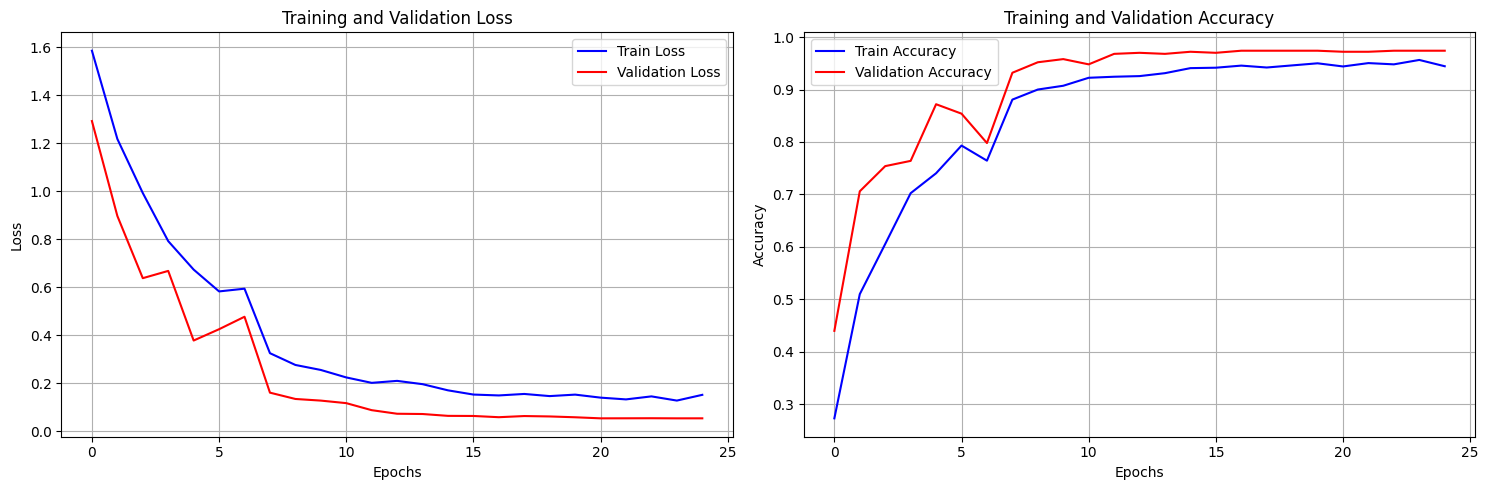

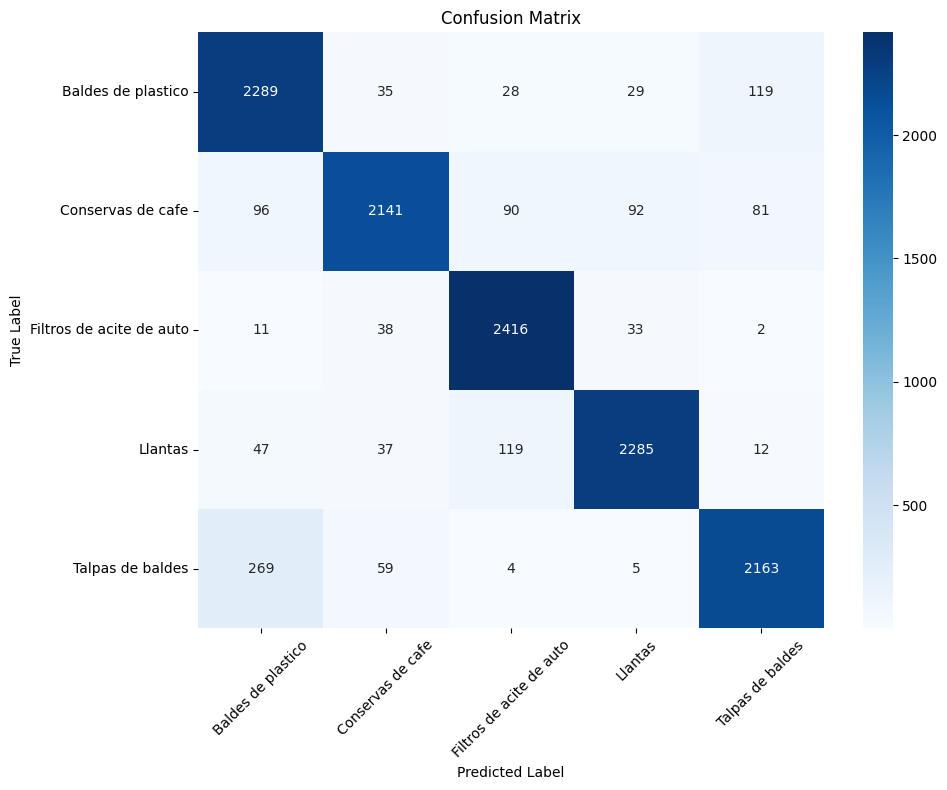

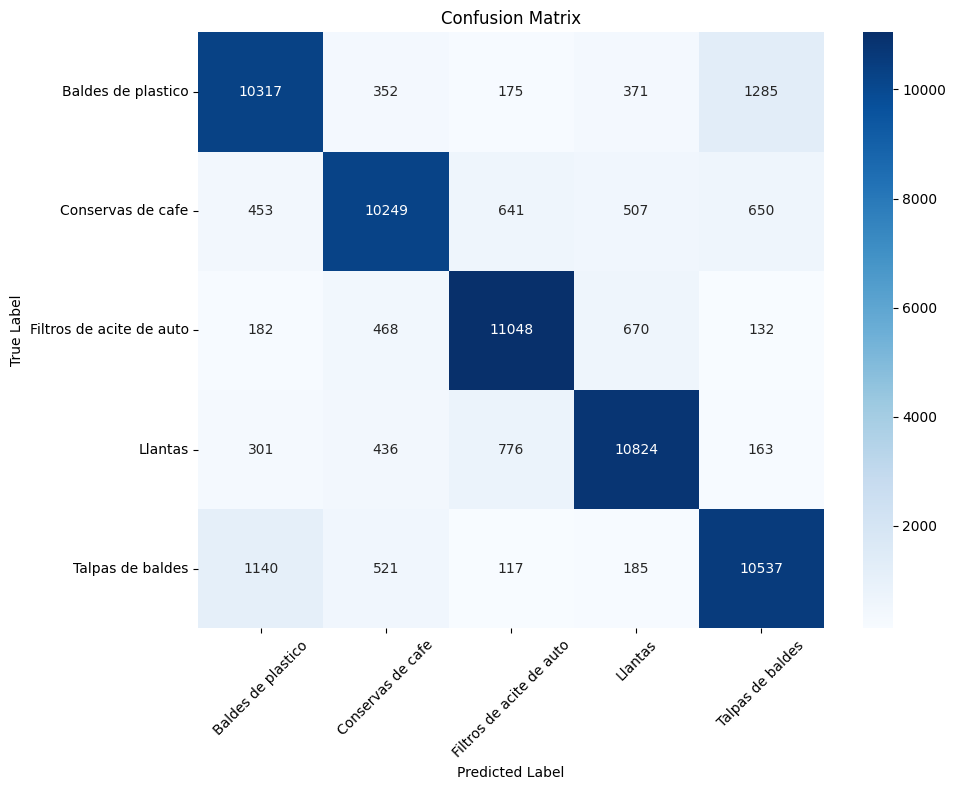

Final Validation Accuracy: 0.9035


In [19]:
# Entrenar el modelo (ahora devuelve métricas)
model_ft, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

# Graficar pérdidas y accuracy
plot_training_metrics(metrics)

# Obtener nombres de clases (ajusta según tu dataset)
class_names = dataloaders['train'].dataset.classes

# Matriz de confusión para validación
cm_val = plot_confusion_matrix(metrics['all_labels']['val'], 
                              metrics['all_preds']['val'], 
                              class_names)

# También puedes hacerlo para training
cm_train = plot_confusion_matrix(metrics['all_labels']['train'], 
                                metrics['all_preds']['train'], 
                                class_names)

# Calcular accuracy final
final_val_accuracy = np.mean(np.array(metrics['all_preds']['val']) == np.array(metrics['all_labels']['val']))
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

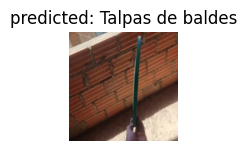

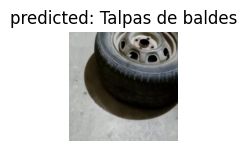

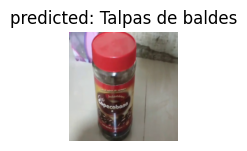

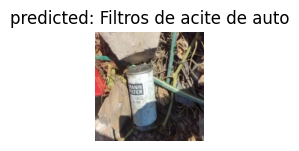

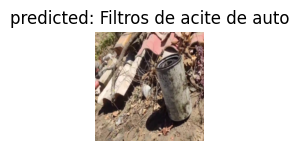

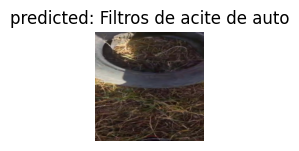

In [21]:
visualize_model(model_ft)

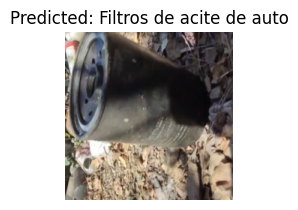

In [22]:
visualize_model_predictions(
    model_ft,
    img_path=r"C:\Users\Admin\Ciencias\Residuos solidos\data\val\Filtros de acite de auto\ikbwomjfjo4n1ho4.jpg"
)

plt.ioff()
plt.show()

## ConvNet as fixed feature extractor
Aquí, necesitamos congelar toda la red excepto la capa final. Debemos configurar requires_grad = False para congelar los parámetros y evitar que los gradientes se calculen en backward().

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models

# Cargar ConvNeXt preentrenado en ImageNet
model_conv = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Congelar todas las capas
for param in model_conv.parameters():
    param.requires_grad = False

# Reemplazar la última capa (classifier) por una nueva con tus clases
num_ftrs = model_conv.classifier[2].in_features
model_conv.classifier[2] = nn.Linear(num_ftrs, 5)  # 5 clases

model_conv = model_conv.to(device)

# Definir loss
criterion = nn.CrossEntropyLoss()

# Optimizar solo los parámetros de la última capa
optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.001, momentum=0.9)

# Scheduler (reduce LR cada 7 épocas por 0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


## Entrenamiento y evalucaion

Epoch 0/24
----------
train Loss: 0.1040 Acc: 0.9808
val Loss: 0.0259 Acc: 0.9980

Epoch 1/24
----------
train Loss: 0.0871 Acc: 0.9812
val Loss: 0.0251 Acc: 0.9980

Epoch 2/24
----------
train Loss: 0.0973 Acc: 0.9760
val Loss: 0.0243 Acc: 0.9980

Epoch 3/24
----------
train Loss: 0.0894 Acc: 0.9800
val Loss: 0.0238 Acc: 0.9980

Epoch 4/24
----------
train Loss: 0.0939 Acc: 0.9780
val Loss: 0.0230 Acc: 0.9980

Epoch 5/24
----------
train Loss: 0.0927 Acc: 0.9784
val Loss: 0.0226 Acc: 0.9980

Epoch 6/24
----------
train Loss: 0.0925 Acc: 0.9752
val Loss: 0.0219 Acc: 0.9980

Epoch 7/24
----------
train Loss: 0.0909 Acc: 0.9796
val Loss: 0.0212 Acc: 0.9980

Epoch 8/24
----------
train Loss: 0.0861 Acc: 0.9800
val Loss: 0.0212 Acc: 0.9980

Epoch 9/24
----------
train Loss: 0.0873 Acc: 0.9780
val Loss: 0.0212 Acc: 0.9980

Epoch 10/24
----------
train Loss: 0.0831 Acc: 0.9808
val Loss: 0.0211 Acc: 0.9980

Epoch 11/24
----------
train Loss: 0.0870 Acc: 0.9764
val Loss: 0.0211 Acc: 0.9980

Ep

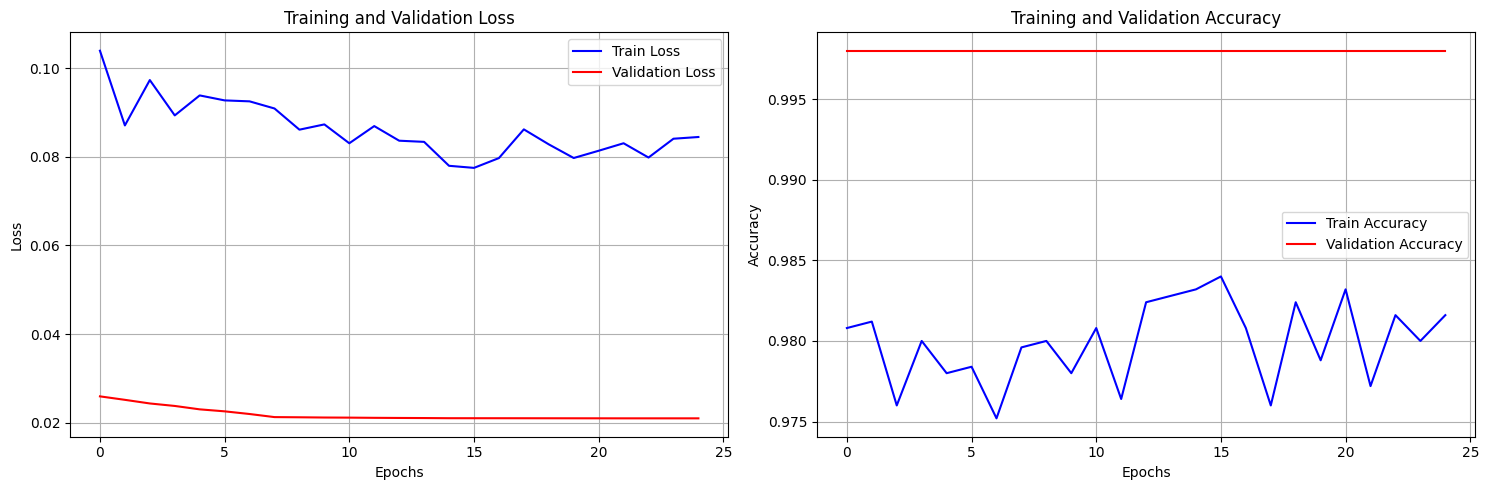

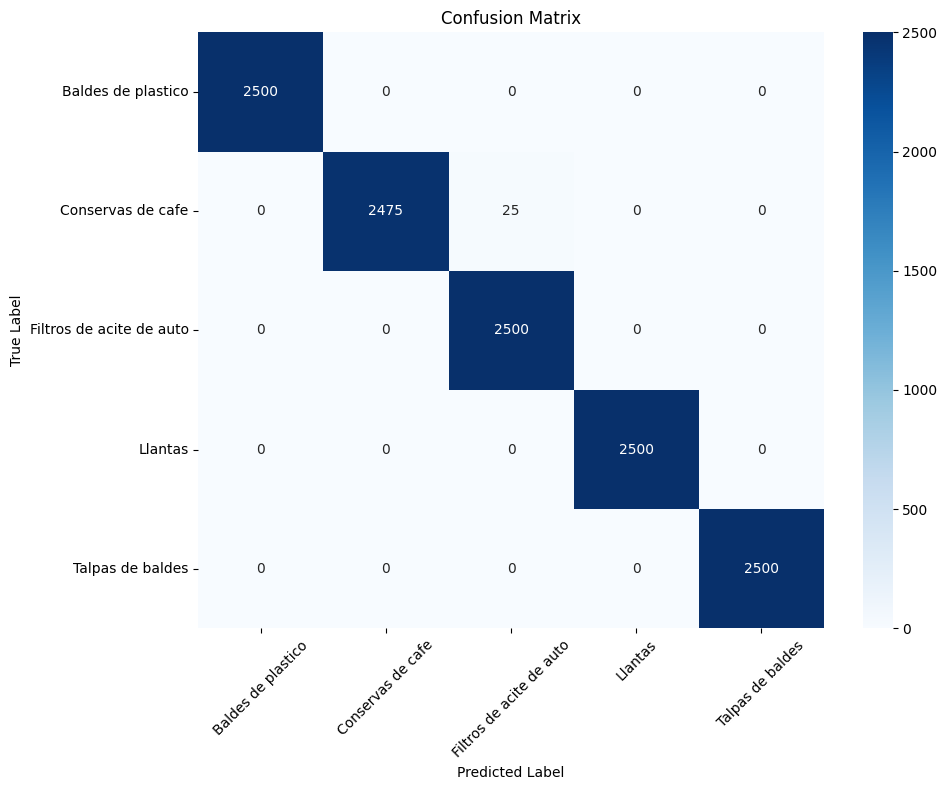

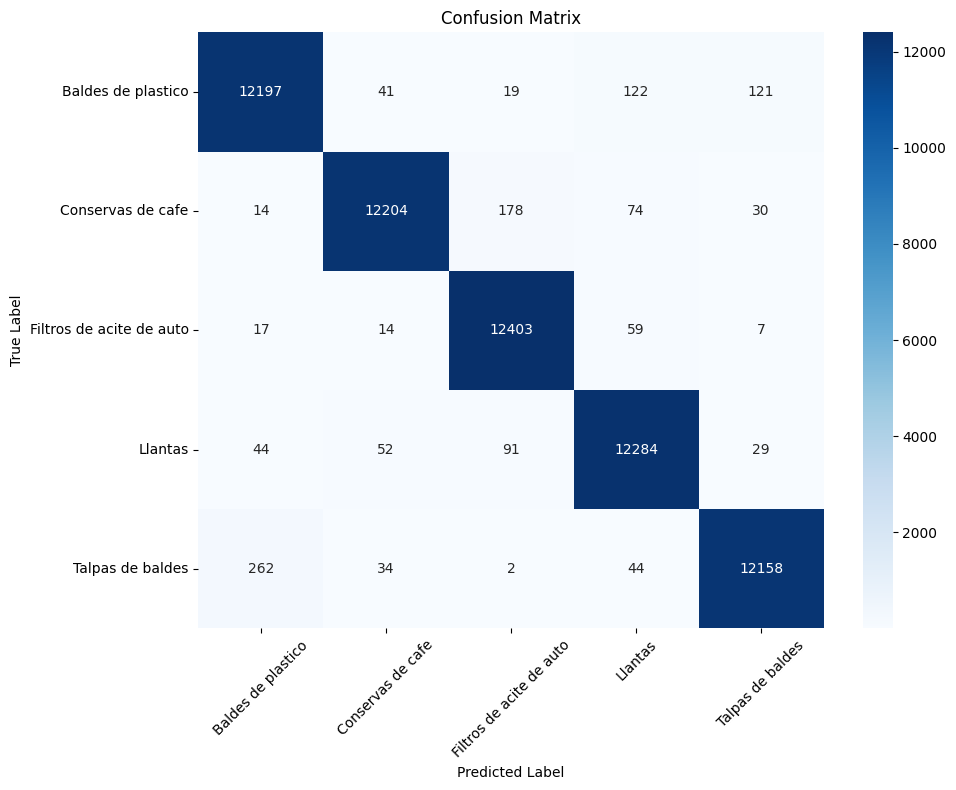

Final Validation Accuracy: 0.9980


In [32]:
# Entrenar el modelo (ahora devuelve métricas)
metrics_conv = {}
model_conv, metrics_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

# Graficar pérdidas y accuracy
plot_training_metrics(metrics_conv)

# Obtener nombres de clases (ajusta según tu dataset)
class_names = dataloaders['train'].dataset.classes

# Matriz de confusión para validación
cm_val = plot_confusion_matrix(metrics_conv['all_labels']['val'], 
                              metrics_conv['all_preds']['val'], 
                              class_names)

# También puedes hacerlo para training
cm_train = plot_confusion_matrix(metrics_conv['all_labels']['train'], 
                                metrics_conv['all_preds']['train'], 
                                class_names)

# Calcular accuracy final
final_val_accuracy = np.mean(np.array(metrics_conv['all_preds']['val']) == np.array(metrics_conv['all_labels']['val']))
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

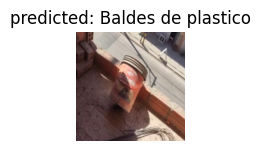

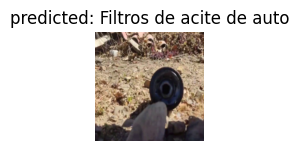

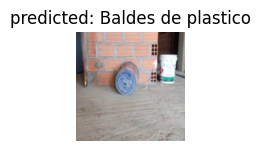

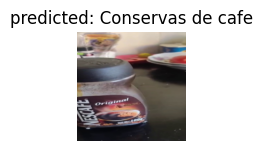

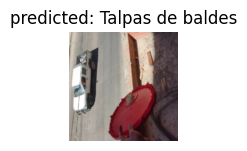

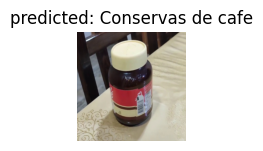

In [33]:
visualize_model(model_conv)

plt.ioff()
plt.show()

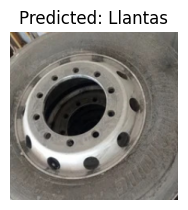

In [34]:
visualize_model_predictions(
    model_conv,
    img_path=r"C:\Users\Admin\Downloads\llanta.jpg"
)

plt.ioff()
plt.show()